In [ ]:
!pip install tqdm==4.28.1
!pip install -U gast==0.2.2
!pip install gdown

!gdown https://drive.google.com/uc?id=14CB3Vw4jPf-8-DAriB9XDq4mfbs4o747
!mkdir datasets
!tar -C datasets -xzf airport-alunos.tgz


In [1]:
import random

#%tensorflow_version 2.x
import tensorflow as tf; print(tf.__version__)
import tensorflow.keras
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import ReLU
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K


from sklearn.datasets import load_sample_image;
from sklearn.manifold import TSNE


import seaborn as sns


import numpy as np
import tqdm; print(tqdm.__version__)
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

TRAINING = False

2.0.0
4.28.1


In [2]:
def scatter(x, labels, subtitle='None'):
    # We choose a color palette with seaborn.
    palette_size = len(np.unique(labels))
    palette = np.array(sns.color_palette("hls", palette_size))
    
    color_map = dict({})
    color_count = 0
    for l in labels:
        if l not in color_map:
            color_map[l] = color_count
            color_count = color_count + 1
    
    def get_color_idx(label):
        return color_map[label]
        
    def get_colores_idx(labels_):
        return np.array([get_color_idx(l) for l in labels_])
        
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[get_colores_idx(labels)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for l, i in zip(labels, range(len(labels))):
        # Position of each label.
        xtext, ytext = np.median(x[labels == l, :], axis=0)
        txt = ax.text(xtext, ytext, labels[i], fontsize=16, 
                      color = palette[get_color_idx(l)]) #, bbox=dict(alpha=0.5))
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="yellow"),
            PathEffects.Normal()])
        txts.append(txt)
        
    if subtitle != None:
        plt.suptitle(subtitle)
        
    plt.savefig(subtitle)

In [3]:
def create_base_model(input_shape):
    input_layer = Input(shape = input_shape)
    
    model = Conv2D(8, (3, 3), activation = None, padding='same')(input_layer)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D((2, 2))(model)
    
    model = Conv2D(16, (3, 3), activation = None, padding='same')(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D((2, 2))(model)
    
    model = Conv2D(32, (3, 3), activation = None, padding='same')(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D((2, 2))(model)
    
    model = Conv2D(64, (3, 3), activation = None, padding='same')(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D((2, 2))(model)
    
    model = Flatten()(model)
    model = Dense(64, activation='relu')(model)
    model = Lambda(lambda inp: K.l2_normalize(inp, axis=-1))(model)
    
    model = Model(inputs=input_layer, outputs=model)
    
    return model

def create_autoencoder(input_shape):
    input_layer = Input(shape = input_shape)
    
    model = Dense(64, activation='relu')(input_layer)
    model = Dense(32, activation='relu')(model)
    model = Dense(16, activation='relu')(model)
    model = Dense(32, activation='relu')(model)
    model = Dense(64, activation='relu')(model)
    model = Lambda(lambda inp: K.l2_normalize(inp, axis=-1))(model)
    
    model = Model(inputs=input_layer, outputs=model)
    
    return model
    
class TripletLossLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(TripletLossLayer, self).__init__()
    
    def euclidean_distance(self, vects):
        x, y = vects
        x = tf.cast(x, 'float32')
        y = tf.cast(y, 'float32')

        return K.mean(K.sum(K.square(x-y),axis=1))
    
    def call(self, inputs=None):
        #     Calcule triplet loss 
        #     loss = max(dist(a, p) - dist(a, n) + margin, 0)
        self.margin = tf.constant(0.4 , dtype='float32')
        a, p, n = inputs
        a = tf.cast(a, 'float32')
        p = tf.cast(p, 'float32')
        n = tf.cast(n, 'float32')
        
        # Calcule triplet loss 
        subt_ = tf.subtract(self.euclidean_distance([a, p]) , self.euclidean_distance([a, n]))
        sum_ = tf.add(subt_, self.margin)
        
        loss = K.maximum(sum_, 0.0)
        # add in model loss
        self.add_loss(loss)
    
        return a

In [4]:
adam = tf.keras.optimizers.Adam(learning_rate=0.00001)
input_shape = (128, 64, 3)

## Defining S1

In [5]:
base_network_s1 = create_base_model(input_shape)

input_anchor = Input(shape=input_shape)
input_positive = Input(shape=input_shape)
input_negative = Input(shape=input_shape)

processed_a = base_network_s1(input_anchor)
processed_p = base_network_s1(input_positive)
processed_n = base_network_s1(input_negative)

loss_layer_s1 = TripletLossLayer()([processed_a, processed_p, processed_n])

s1 = Model([input_anchor, input_positive, input_negative], loss_layer_s1)

s1.compile(optimizer=adam, loss=(lambda y_true, ypred: 0.0))

s1_embs_model = base_network_s1
s1_embs_model.compile(loss=(lambda y_true, ypred: 0.0))

## Defining S2

In [6]:
base_network_s2 = create_base_model(input_shape)
autoencoder_s2 = create_autoencoder((64,))

d = Dense(64, activation='relu')(base_network_s2.output)
middle_model_s2 = Model(base_network_s2.input, d)

connect = autoencoder_s2(middle_model_s2.output)
middle_model_s2 = Model(base_network_s2.input, connect)

input_anchor_s2 = Input(shape=input_shape)
input_positive_s2 = Input(shape=input_shape)
input_negative_s2 = Input(shape=input_shape)

processed_a_s2 = middle_model_s2(input_anchor_s2)
processed_p_s2 = middle_model_s2(input_positive_s2)
processed_n_s2 = middle_model_s2(input_negative_s2)

loss_layer_s2 = TripletLossLayer()([processed_a_s2, processed_p_s2, processed_n_s2])

s2 = Model([input_anchor_s2, input_positive_s2, input_negative_s2], 
           loss_layer_s2)
s2.compile(optimizer=adam, loss=(lambda y_true, ypred: 0.0))

s2_embs_model = base_network_s2
s2_embs_model.compile(loss=(lambda y_true, ypred: 0.0))

## Defining S3

In [7]:
base_network_s3 = create_base_model(input_shape)
autoencoder_s3 = create_autoencoder((64,))

d = Dense(64, activation='relu')(base_network_s3.output)
middle_model_s3 = Model(base_network_s3.input, d)

connect3 = autoencoder_s3(middle_model_s3.output)
middle_model_s3 = Model(base_network_s3.input, connect3)

input_anchor_s3 = Input(shape=input_shape)
input_positive_s3 = Input(shape=input_shape)
input_negative_s3 = Input(shape=input_shape)

processed_a_s3 = middle_model_s3(input_anchor_s3)
processed_p_s3 = middle_model_s3(input_positive_s3)
processed_n_s3 = middle_model_s3(input_negative_s3)

loss_layer_s3 = TripletLossLayer()([processed_a_s3, processed_p_s3, processed_n_s3])

s3 = Model([input_anchor_s3, input_positive_s3, input_negative_s3], 
           loss_layer_s3)
s3.compile(optimizer=adam, loss=(lambda y_true, ypred: 0.0))

autoencoder_s3.compile(optimizer=adam, loss='mse')

s3_embs_model = base_network_s3
s3_embs_model.compile(loss=(lambda y_true, ypred: 0.0))

## Experiments With Real Dataset

In [8]:
from tripplet_data import *

early_stopping =  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0,
                                                         verbose=0, restore_best_weights=True)

def map_person_to_filepaths(folder='treino'):
    path = 'datasets/airport-alunos/' + folder + '/'
    images_per_person = {}
    
    for i in range(2):
        for (person, person_path) in map_person_files(path + str(i) +'/').items():
            for pp in person_path:
                if person not in images_per_person:
                    images_per_person[person] = []

                for img in list_person_files(pp):
                    images_per_person[person].append(pp + img)
            
    return images_per_person 

def create_embeddings(map_files, embs_model, debbug=False):
    embeddings_per_person = {}
    images_per_person = {}

    total = len(map_files)
    count = 1
    for (person, images_path) in map_files.items():
        np_images = []
        for ip in images_path:
            np_image = img_to_array(load_img(ip))
            np_images.append(np_image)
        
        images_per_person
        if debbug:
            print("(" + str(count)+ "/" + str(total) +") predicting to person "+ person)
            
        count = count + 1
        embs_output = embs_model.predict(np.array(np_images))
        
        images_per_person[person] = np_images
        embeddings_per_person[person] = embs_output
    
    return embeddings_per_person, images_per_person


def create_triplets(number_of_triples, embeddings_map, images_map):
    def get_distance(emb1, emb2):
        return np.sqrt(np.sum(np.power((emb1 - emb2), 2)))
    persons = np.array([name for (name, _) in embeddings_map.items()])

    anchors = []
    positives = []
    negatives = []

    for ll in range(number_of_triples):
        anchor_person = random.choice(persons)
        neg_person = anchor_person
        while anchor_person == neg_person:
            neg_person = random.choice(persons)

        anchor_idx = np.random.randint(len(embeddings_map[anchor_person]))
        anchor_emb = embeddings_map[anchor_person][anchor_idx]
        anchor_img = images_map[anchor_person][anchor_idx]

        # Select the farthest on as positive
        farthest_idx = 0
        farthest_dist = -10000
        for i in range(len(embeddings_map[anchor_person])):
            dist = get_distance(anchor_emb, embeddings_map[anchor_person][i])
            if dist > farthest_dist:
                farthest_dist = dist
                farthest_idx = i
        positive_img = images_map[anchor_person][farthest_idx]

        # Select the nearst on as negative
        nearst_idx = 0
        nearst_dist = 10000
        for i in range(len(embeddings_map[neg_person])):
            dist = get_distance(anchor_emb, embeddings_map[neg_person][i])
            if dist < nearst_dist:
                nearst_dist = dist
                nearst_idx = i
        negative_img = images_map[neg_person][nearst_idx]

        anchors.append(anchor_img)
        positives.append(positive_img)
        negatives.append(negative_img)

    y_true = np.array([[0.0 for _ in range(64)] for _ in range(number_of_triples)])
    
    return [np.array(anchors), np.array(positives), np.array(negatives)], y_true

def create_tuplets(number_of_tuplets, embeddings_map, images_map, positive_proportion=0.5):
    persons = np.array([name for (name, _) in embeddings_map.items()])

    anchors = []
    others = []
    y_true = np.array([[1] for _ in range(number_of_tuplets)])
    
    for ll in range(number_of_tuplets):
        anchor_person = random.choice(persons)
        other_person = anchor_person
    
        if np.random.rand() > positive_proportion: 
            # Other person
            y_true[ll][0] = 0
            while anchor_person == other_person:
                other_person = random.choice(persons)
        
        

        anchor_idx = np.random.randint(len(embeddings_map[anchor_person]))
        anchor_emb = embeddings_map[anchor_person][anchor_idx]
        anchor_img = images_map[anchor_person][anchor_idx]
        
        other_idx = np.random.randint(len(embeddings_map[other_person]))
        other_emb = embeddings_map[other_person][other_idx]
        other_img = images_map[other_person][other_idx]
        
        anchors.append(anchor_emb)
        others.append(other_emb)
    
    return [np.array(anchors), np.array(others)], y_true

2.0.0


# =========================    S1   ==============================

### Show TSNE Before Training

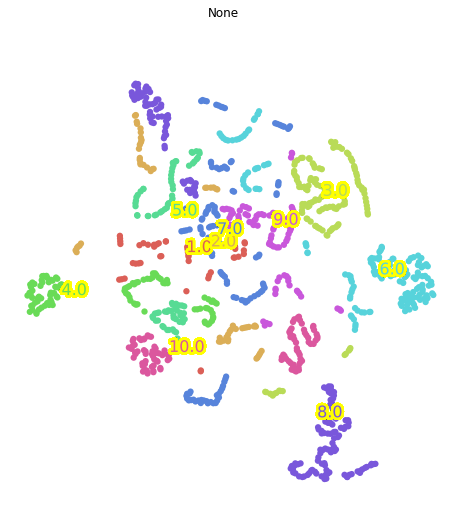

In [9]:
if TRAINING:
    embeddings, images = create_embeddings(map_person_to_filepaths('val'), s1_embs_model, debbug=False)

    combined_embs = np.zeros(shape=(0,64))
    labels = np.zeros(shape=(0,1))
    count = 1
    for (person, embs) in embeddings.items():
        combined_embs = np.append( combined_embs,  embs, axis=0)
        l = np.zeros((len(embs), 1)) + count
        labels = np.append( labels,  l, axis=0)
        count = count + 1
        if count>10:
            break

    labels = labels.flatten()
    embs_2d = TSNE().fit_transform(combined_embs)
    scatter(embs_2d, labels)

In [9]:
if TRAINING:
    for _ in range(100):
        embeddings_treino, images_treino = create_embeddings(map_person_to_filepaths('treino'), 
                                                             s1_embs_model, debbug=False)
        embeddings_val, images_val = create_embeddings(map_person_to_filepaths('val'), 
                                                             s1_embs_model, debbug=False)

        for _ in range(10):
            x_train, y_train = create_triplets(10000, embeddings_treino, images_treino)
            x_val, y_val = create_triplets(1000, embeddings_val, images_val)

            s1.fit(x_train, y_train, epochs=10000, shuffle=True, callbacks=[early_stopping], batch_size=32,
                             validation_data=(x_val, y_val))

            del y_train
            del y_val
            for k in range(3):
                del x_val[0]
                del x_train[0]

            print("Saving weig..")
            s1.save_weights('s1_weights.h5')


        del embeddings_treino
        del embeddings_val
        del images_treino
        del images_val
else:
    s1.load_weights('s1_weights.h5')

### Show TSNE After Training

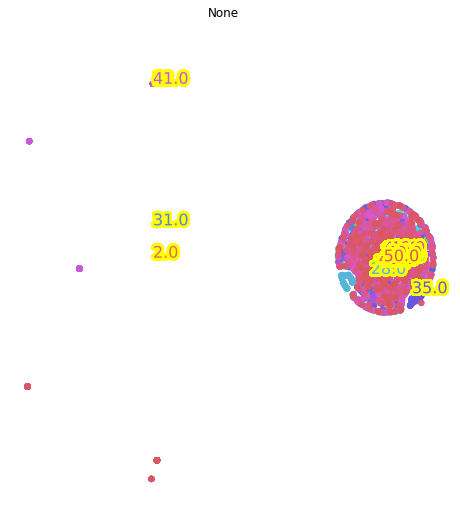

In [10]:
embeddings_val, images_val = create_embeddings(map_person_to_filepaths('val'), 
                                                         s1_embs_model, debbug=False)

combined_embs = np.zeros(shape=(0,64))
labels = np.zeros(shape=(0,1))
count = 1
for (person, embs) in embeddings_val.items():
    combined_embs = np.append( combined_embs,  embs, axis=0)
    l = np.zeros((len(embs), 1)) + count
    labels = np.append( labels,  l, axis=0)
    count = count + 1
#     if count>10:
#         break

labels = labels.flatten()
embs_2d = TSNE().fit_transform(combined_embs)
scatter(embs_2d, labels)

## Evaluation of model

* Get Embeddings
* Create a shallow neural network
* Train this network to decide if two embs is from the same person

In [11]:
embeddings_treino, images_treino = create_embeddings(map_person_to_filepaths('treino'), 
                                                         s1_embs_model, debbug=False)

embeddings_val, images_val = create_embeddings(map_person_to_filepaths('val'), 
                                                         s1_embs_model, debbug=False)

In [12]:
pred_model_inp_a = Input(shape=(64,))
pred_model_inp_b = Input(shape=(64,))

pred_model = Dense(64, activation='elu')(tf.keras.layers.concatenate([pred_model_inp_a, pred_model_inp_b]))
pred_model = BatchNormalization()(pred_model)

pred_model = Dense(64, activation='elu')(pred_model)
pred_model = BatchNormalization()(pred_model)

pred_model = Dense(32, activation='elu')(pred_model)
pred_model = BatchNormalization()(pred_model)

pred_model = Dense(16, activation='elu')(pred_model)
pred_model = BatchNormalization()(pred_model)

pred_model_output = Dense(1, activation='sigmoid')(pred_model)

s1_pred_model = Model(inputs=[pred_model_inp_a, pred_model_inp_b], outputs=pred_model_output)

s1_pred_model.compile(loss='binary_crossentropy', optimizer='adam')

In [14]:
if TRAINING:
    for _ in range(10):
        x_treino, y_treino = create_tuplets(10000, embeddings_treino, images_treino)
        x_val, y_val = create_tuplets(1000, embeddings_val, images_val)

        s1_pred_model.fit(x_treino, y_treino, batch_size=16, shuffle=True, callbacks=[early_stopping],
                         epochs=1000, validation_data=(x_val, y_val))

        del y_treino
        del y_val
        for k in range(2):
            del x_val[0]
            del x_treino[0]

        s1_pred_model.save_weights('s1_pred_model.h5')
else:
    s1_pred_model.load_weights('s1_pred_model.h5')

In [16]:
x_val, y_val = create_tuplets(10000, embeddings_val, images_val, positive_proportion=0.5)
y_pred = s1_pred_model.predict(x_val)

y_pred = (y_pred>.5).flatten()
y_true = (y_val>.5).flatten()

accuracy = np.sum(y_pred==y_true)/len(y_true)*100

print(accuracy)

57.42


# =========================    S2   ==============================

### Show TSNE Before Training

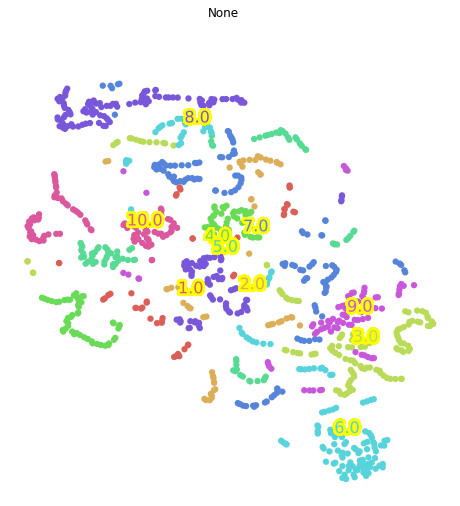

In [10]:
if TRAINING:
    embeddings, images = create_embeddings(map_person_to_filepaths('val'), s2_embs_model, debbug=False)
    
    combined_embs = np.zeros(shape=(0,64))
    labels = np.zeros(shape=(0,1))
    count = 1
    for (person, embs) in embeddings.items():
        combined_embs = np.append( combined_embs,  embs, axis=0)
        l = np.zeros((len(embs), 1)) + count
        labels = np.append( labels,  l, axis=0)
        count = count + 1
        if count>10:
            break

    labels = labels.flatten()
    embs_2d = TSNE().fit_transform(combined_embs)
    scatter(embs_2d, labels)

In [17]:
if TRAINING:
    for _ in range(100):
        embeddings_treino, images_treino = create_embeddings(map_person_to_filepaths('treino'), 
                                                             s2_embs_model, debbug=False)
        embeddings_val, images_val = create_embeddings(map_person_to_filepaths('val'), 
                                                             s2_embs_model, debbug=False)



        for _ in range(10):
            x_train, y_train = create_triplets(10000, embeddings_treino, images_treino)
            x_val, y_val = create_triplets(1000, embeddings_val, images_val)

            s2.fit(x_train, y_train, epochs=10000, shuffle=True, callbacks=[early_stopping], batch_size=32,
                             validation_data=(x_val, y_val))

            del y_train
            del y_val
            for k in range(3):
                del x_val[0]
                del x_train[0]

            s2.save_weights('s2_weights.h5')

        del embeddings_treino
        del embeddings_val
        del images_treino
        del images_val
else:
    s2.load_weights('s2_weights.h5')    

### Show TSNE After Training

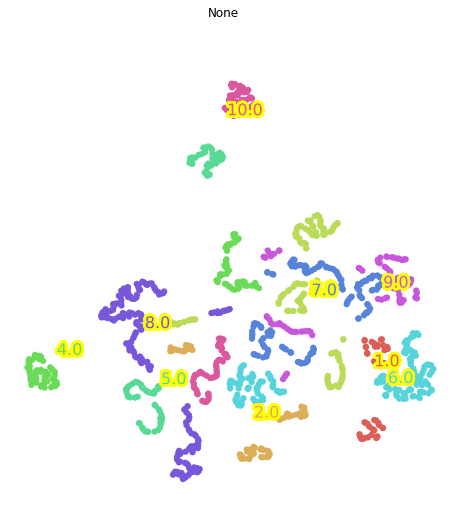

In [18]:
embeddings_val, images_val = create_embeddings(map_person_to_filepaths('val'), 
                                                         s2_embs_model, debbug=False)

combined_embs = np.zeros(shape=(0,64))
labels = np.zeros(shape=(0,1))
count = 1
for (person, embs) in embeddings_val.items():
    combined_embs = np.append( combined_embs,  embs, axis=0)
    l = np.zeros((len(embs), 1)) + count
    labels = np.append( labels,  l, axis=0)
    count = count + 1
    if count>10:
        break

labels = labels.flatten()
embs_2d = TSNE().fit_transform(combined_embs)
scatter(embs_2d, labels)

## Evaluation of model

* Get Embeddings
* Create a shallow neural network
* Train this network to decide if two embs is from the same person

In [19]:
embeddings_treino, images_treino = create_embeddings(map_person_to_filepaths('treino'), 
                                                         s2_embs_model, debbug=False)

embeddings_val, images_val = create_embeddings(map_person_to_filepaths('val'), 
                                                         s2_embs_model, debbug=False)

In [20]:
pred_model_inp_a = Input(shape=(64,))
pred_model_inp_b = Input(shape=(64,))

pred_model = Dense(64, activation='elu')(tf.keras.layers.concatenate([pred_model_inp_a, pred_model_inp_b]))
pred_model = BatchNormalization()(pred_model)

pred_model = Dense(64, activation='elu')(pred_model)
pred_model = BatchNormalization()(pred_model)

pred_model = Dense(32, activation='elu')(pred_model)
pred_model = BatchNormalization()(pred_model)

pred_model = Dense(16, activation='elu')(pred_model)
pred_model = BatchNormalization()(pred_model)

pred_model_output = Dense(1, activation='sigmoid')(pred_model)

s2_pred_model = Model(inputs=[pred_model_inp_a, pred_model_inp_b], outputs=pred_model_output)

s2_pred_model.compile(loss='binary_crossentropy', optimizer='adam')

In [21]:
if TRAINING:
    for _ in range(10):
        x_treino, y_treino = create_tuplets(10000, embeddings_treino, images_treino)
        x_val, y_val = create_tuplets(1000, embeddings_val, images_val)

        s2_pred_model.fit(x_treino, y_treino, batch_size=16, shuffle=True, callbacks=[early_stopping],
                         epochs=1000, validation_data=(x_val, y_val))

        del y_treino
        del y_val
        for k in range(2):
            del x_val[0]
            del x_treino[0]

        s2_pred_model.save_weights('s2_pred_model.h5')
else:
    s2_pred_model.load_weights('s2_pred_model.h5')

In [22]:
x_val, y_val = create_tuplets(10000, embeddings_val, images_val, positive_proportion=0.1)
y_pred = s2_pred_model.predict(x_val)

y_pred = (y_pred>.5).flatten()
y_true = (y_val>.5).flatten()

accuracy = np.sum(y_pred==y_true)/len(y_true)*100

print(accuracy)

68.61


# =========================    S3   ==============================

### Show TSNE Before Training

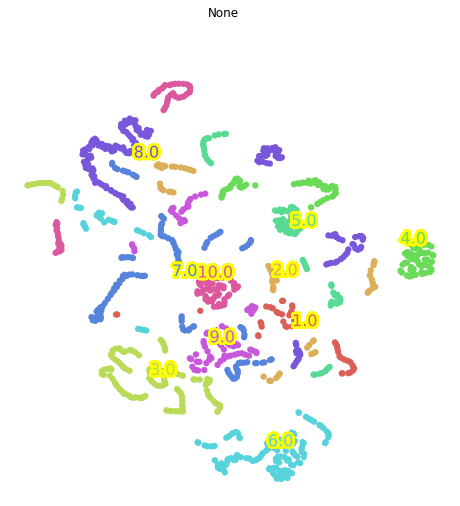

In [11]:
if TRAINING:
    embeddings, images = create_embeddings(map_person_to_filepaths('val'), s3_embs_model, debbug=False)
    combined_embs = np.zeros(shape=(0,64))
    labels = np.zeros(shape=(0,1))
    count = 1
    for (person, embs) in embeddings.items():
        combined_embs = np.append( combined_embs,  embs, axis=0)
        l = np.zeros((len(embs), 1)) + count
        labels = np.append( labels,  l, axis=0)
        count = count + 1
        if count>10:
            break

    labels = labels.flatten()
    embs_2d = TSNE().fit_transform(combined_embs)
    scatter(embs_2d, labels)

In [23]:
if TRAINING:
    for _ in range(100):
        embeddings_treino, images_treino = create_embeddings(map_person_to_filepaths('treino'), 
                                                             s3_embs_model, debbug=False)
        embeddings_val, images_val = create_embeddings(map_person_to_filepaths('val'), 
                                                             s3_embs_model, debbug=False)
        all_embs_treino = []
        all_embs_val = []
        for (person, embs) in embeddings_val.items():
            for emb in embs:
                all_embs_val.append(emb)
        for (person, embs) in embeddings_treino.items():
            for emb in embs:
                all_embs_treino.append(emb)

        np_all_embs_val = np.array(all_embs_val)
        np_all_embs_treino = np.array(all_embs_treino)


        # Train autoencoder
        autoencoder_s3.fit(np_all_embs_treino, np_all_embs_treino, epochs=50, shuffle=True, batch_size=32, 
                          callbacks=[early_stopping], validation_data=(np_all_embs_val, np_all_embs_val))

        del np_all_embs_treino
        del np_all_embs_val


        for _ in range(10):
            x_train, y_train = create_triplets(10000, embeddings_treino, images_treino)
            x_val, y_val = create_triplets(1000, embeddings_val, images_val)

            s3.fit(x_train, y_train, epochs=10000, shuffle=True, callbacks=[early_stopping], batch_size=32,
                             validation_data=(x_val, y_val))

            del y_train
            del y_val
            for k in range(3):
                del x_val[0]
                del x_train[0]

            s3.save_weights('s3_weights.h5')

        del embeddings_treino
        del embeddings_val
        del images_treino
        del images_val
else:
    s3.load_weights('s3_weights.h5')

### Show TSNE After Training

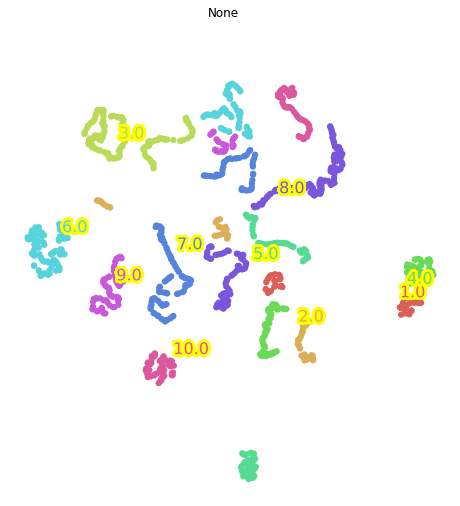

In [24]:
embeddings_val, images_val = create_embeddings(map_person_to_filepaths('val'), 
                                                         s3_embs_model, debbug=False)

combined_embs = np.zeros(shape=(0,64))
labels = np.zeros(shape=(0,1))
count = 1
for (person, embs) in embeddings_val.items():
    combined_embs = np.append( combined_embs,  embs, axis=0)
    l = np.zeros((len(embs), 1)) + count
    labels = np.append( labels,  l, axis=0)
    count = count + 1
    if count>10:
        break

labels = labels.flatten()
embs_2d = TSNE().fit_transform(combined_embs)
scatter(embs_2d, labels)

## Evaluation of model

* Get Embeddings
* Create a shallow neural network
* Train this network to decide if two embs is from the same person

In [32]:
embeddings_treino, images_treino = create_embeddings(map_person_to_filepaths('treino'), 
                                                         s3_embs_model, debbug=False)

embeddings_val, images_val = create_embeddings(map_person_to_filepaths('val'), 
                                                         s3_embs_model, debbug=False)

In [33]:
pred_model_inp_a = Input(shape=(64,))
pred_model_inp_b = Input(shape=(64,))

pred_model = Dense(64, activation='elu')(tf.keras.layers.concatenate([pred_model_inp_a, pred_model_inp_b]))
pred_model = BatchNormalization()(pred_model)

pred_model = Dense(64, activation='elu')(pred_model)
pred_model = BatchNormalization()(pred_model)

pred_model = Dense(32, activation='elu')(pred_model)
pred_model = BatchNormalization()(pred_model)

pred_model = Dense(16, activation='elu')(pred_model)
pred_model = BatchNormalization()(pred_model)

pred_model_output = Dense(1, activation='sigmoid')(pred_model)

s3_pred_model = Model(inputs=[pred_model_inp_a, pred_model_inp_b], outputs=pred_model_output)

s3_pred_model.compile(loss='binary_crossentropy', optimizer='adam')

In [34]:
if TRAINING:
    for _ in range(10):
        x_treino, y_treino = create_tuplets(10000, embeddings_treino, images_treino)
        x_val, y_val = create_tuplets(1000, embeddings_val, images_val)

        s3_pred_model.fit(x_treino, y_treino, batch_size=16, shuffle=True, callbacks=[early_stopping],
                         epochs=1000, validation_data=(x_val, y_val))

        del y_treino
        del y_val
        for k in range(2):
            del x_val[0]
            del x_treino[0]

        s3_pred_model.save_weights('s3_pred_model.h5')
else:
    s3_pred_model.load_weights('s3_pred_model.h5')

In [37]:
x_val, y_val = create_tuplets(10000, embeddings_val, images_val, positive_proportion=0.1)
y_pred = s3_pred_model.predict(x_val)

y_pred = (y_pred>.5).flatten()
y_true = (y_val>.5).flatten()

accuracy = np.sum(y_pred==y_true)/len(y_true)*100

print(accuracy)

70.12
